# Визуализация мешей на фоне TRT postscript сечений

In [1]:
import sys

sys.version, sys.prefix

('3.13.9 (main, Oct 14 2025, 21:29:44) [Clang 20.1.4 ]',
 '/home/dvp/dev/mckit-meshes/.venv')

In [50]:
from pathlib import Path

import numpy as np

In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors, colormaps as cm

In [4]:
%matplotlib inline

In [46]:
# plt.style.available

In [47]:
# mpl.use("Qt5agg")
font = {
    "weight": "normal",
    "size": 12,
}
plt.rc("font", **font)
plt.rcParams["mathtext.default"] = "regular"
INCH = 2.54
FIG_WIDTH = int(
    10.6 / INCH
)  # Optimal for full page witdh graphs, for 1 column graph in 2 column publications use 8cm.
FIG_HEIGHT = FIG_WIDTH
plt.rcParams["figure.figsize"] = (FIG_WIDTH, FIG_HEIGHT)
plt.style.use("fivethirtyeight")
plt.rc("grid", color="gray", linestyle="solid")
plt.rc("xtick", direction="out", color="gray")
plt.rc("ytick", direction="out", color="gray")

In [21]:
from mckit_meshes.plot import load_plotm_file, Page, plot_ps_page, BriefTicksAroundOneTicker, plot_2d_distribution

In [6]:
from mckit_meshes.fmesh import FMesh

In [7]:
TRT_ROOT = Path("~/dev/mcnp/trt").expanduser()
assert TRT_ROOT.is_dir()

In [8]:
PROTOTYPE_DIR = TRT_ROOT / "mcnp-5/prototype"
assert PROTOTYPE_DIR.is_dir()

In [9]:
PLOTM_DIR = PROTOTYPE_DIR / "plotm"
assert PLOTM_DIR.is_dir()

In [10]:
ps_files = list(PLOTM_DIR.glob("*.ps"))
assert ps_files
ps_files

[PosixPath('/home/dvp/dev/mcnp/trt/mcnp-5/prototype/plotm/pz=50.ps'),
 PosixPath('/home/dvp/dev/mcnp/trt/mcnp-5/prototype/plotm/ports-vertical-cut.ps'),
 PosixPath('/home/dvp/dev/mcnp/trt/mcnp-5/prototype/plotm/pz=0-rotated.ps'),
 PosixPath('/home/dvp/dev/mcnp/trt/mcnp-5/prototype/plotm/py=0-tc-vertical-cut.ps')]

In [11]:
pages = { p.stem: load_plotm_file(p)[0] for p in ps_files }
len(pages)

4

In [17]:
!ls {PROTOTYPE_DIR}/results/heat-3/npz/heat-3-5.7e09

1014.npz  1054.npz  1094.npz  1134.npz	1214.npz  1254.npz  1294.npz
1024.npz  1064.npz  1104.npz  1144.npz	1224.npz  1264.npz  1304.npz
1034.npz  1074.npz  1114.npz  1154.npz	1234.npz  1274.npz  1314.npz
1044.npz  1084.npz  1124.npz  1164.npz	1244.npz  1284.npz  1324.npz


## Survey tallies

- 1214 - n flux 
- 1224 - n actual heating, W/cm3
- 1234 - n steel heating, W/cm3
- 1284 - n dose, uSv/h
- 1294 - p dose, uSv/h
- 1304 - p flux
- 1314 - p actual heating, W/cm3
- 1324 - p steel heating, W/cm3


## neutron total flux

In [18]:
NPZ_DIR = PROTOTYPE_DIR / "results/heat-3/npz/heat-3-5.7e09"
assert NPZ_DIR.is_dir()

In [19]:
neutron_flux_mesh = FMesh.load_npz(NPZ_DIR / "1214.npz")

In [22]:
neutron_flux_mesh.totals.shape

(100, 100, 70)

In [29]:
eq_mid_height_idx = neutron_flux_mesh.kbins.searchsorted(50)
0.5*(neutron_flux_mesh.kbins[eq_mid_height_idx-1] + neutron_flux_mesh.kbins[eq_mid_height_idx])

np.float64(49.24)

In [31]:
data = neutron_flux_mesh.totals[:,:, eq_mid_height_idx - 1]
data.shape

(100, 100)

In [65]:
x, y = neutron_flux_mesh.ibins, neutron_flux_mesh.jbins
X, Y = np.meshgrid(x, y)

In [105]:
def plot_2d_distribution(x, y, data, fig, ax,
    *,
    color_bar_title=r"$\frac{1} {cm^{2} \cdot s}$",
    max_log_power=None,
    min_max_log_ratio=1e-4,
    transform=None,
):
    if max_log_power is None:
        max_log_power = int(np.log10(data.max()))
    vmax = 10.0**max_log_power
    vmin = data.min()
    min_log_power = int(np.log10(vmin)) + 1
    vmin = max(min_max_log_ratio * vmax, 10.0**min_log_power)
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap("hot")
    pcm = ax.pcolormesh(
        x,
        y,
        data,
        norm=norm,
        cmap=cmap,
        # antialiased=True,
        # shading="gouraud",
        shading="flat",
        # transform=transform,
    )
    color_bar = fig.colorbar(pcm, ax=ax, shrink=0.8)
    color_bar.ax.set_title(color_bar_title, fontsize=8)
    tick_formatter = BriefTicksAroundOneTicker()
    color_bar.ax.yaxis.set_major_formatter(tick_formatter)
    color_bar.outline.set_edgecolor("white")
    

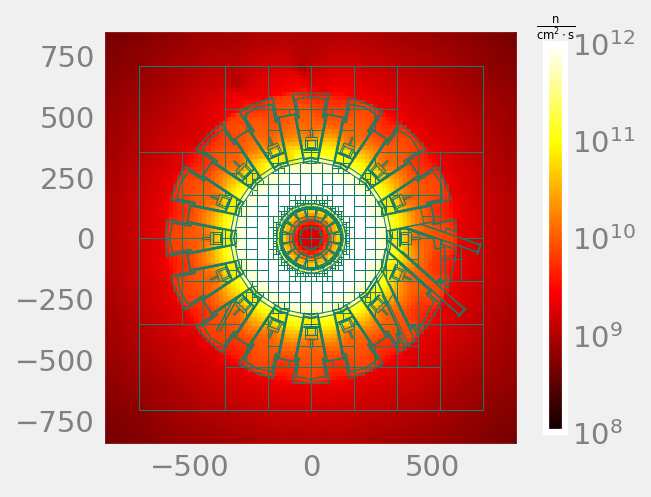

In [98]:
p = pages["pz=50"]
fig = plt.figure(dpi=150)
axes = fig.add_subplot(111)
axes.set_aspect("equal")
axes.set_xlim(x[0], x[-1])
axes.set_ylim(y[0], y[-1])
plot_ps_page(axes, p)
plot_2d_distribution(x, y, data, fig, axes)
plt.savefig((NPZ_DIR / "total-neutron-flux-pz=50").with_suffix(".png"), dpi=1200)
plt.show()

In [103]:
photon_flux_mesh = FMesh.load_npz(NPZ_DIR / "1304.npz")

In [104]:
photon_data = photon_flux_mesh.totals[:,:, eq_mid_height_idx - 1]

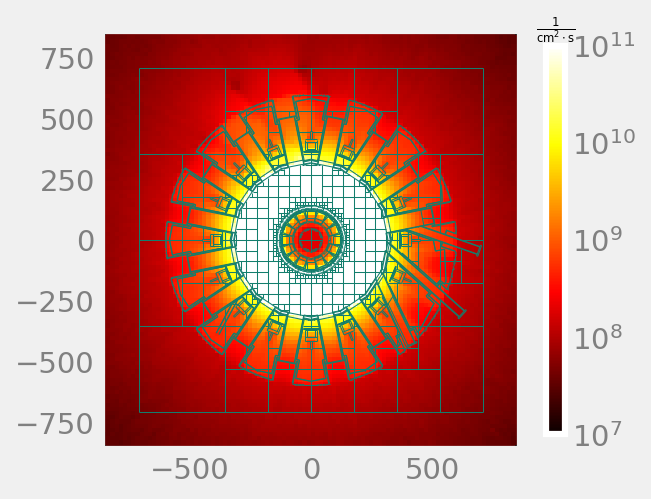

In [106]:
p = pages["pz=50"]
fig = plt.figure(dpi=150)
axes = fig.add_subplot(111)
axes.set_aspect("equal")
axes.set_xlim(x[0], x[-1])
axes.set_ylim(y[0], y[-1])
plot_ps_page(axes, p)
plot_2d_distribution(x, y, photon_data, fig, axes)
plt.savefig((NPZ_DIR / "total-photon-flux-pz=50").with_suffix(".png"), dpi=1200)
plt.show()